# Boston Housing Price Prediction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import boston_housing
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) =  boston_housing.load_data()

In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(404, 13)
(404,)
(102, 13)
(102,)


In [4]:
X_train[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

[Features]
1. Per capita crime rate.
2. Proportion of residential land zoned for lots over 25,000 square feet.
3. Proportion of non-retail business acres per town.
4. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
5. Nitric oxides concentration (parts per 10 million).
6. Average number of rooms per dwelling.
7. Proportion of owner-occupied units built prior to 1940.
8. Weighted distances to five Boston employment centres.
9. Index of accessibility to radial highways.
10. Full-value property-tax rate per $10,000.
11. Pupil-teacher ratio by town.
12. 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
13. % lower status of the population.

[Target]
The median values of owner-occupied homes, in thousands of dollars.

## Preparing the data

In [5]:
mean = X_train.mean(axis=0)
X_train -= mean
std = X_train.std(axis=0)
X_train /= std

# Use the training data for normalizing the test data. (Never use any quantity computed on the test data)
X_test -= mean
X_test /= std

In [6]:
X_train[0]

array([-0.27224633, -0.48361547, -0.43576161, -0.25683275, -0.1652266 ,
       -0.1764426 ,  0.81306188,  0.1166983 , -0.62624905, -0.59517003,
        1.14850044,  0.44807713,  0.8252202 ])

## Building the network

- MSE (Mean Squared Error)
    - the square of the difference between the predictions and the targets.
    - widely used loss function for regression problems.
- MAE (Mean Absolute Error)
    - the absolute value of the difference between the predictions and the targets.

In [7]:
def build_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1)  # No activation for scalar regression
    ])
    model.compile(optimizer='rmsprop',
                  loss='mse',
                  metrics=['mae'])  
    
    return model

## Validating an approach using K-fold validation

- Splitting the available data into K partitions (typically K=4 or 5), then instantiating K identical models.
- Training each one on K-1 partitions while evaluating on the remaining partition.
- The validation score for the model used would then be the average of the K validation scores obtained.

In [8]:
k = 4
num_val = len(X_train) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('Processing fold #', i)
    
    # Prepare the validation data
    X_val = X_train[i*num_val : (i+1)*num_val]
    y_val = y_train[i*num_val : (i+1)*num_val]

    # Prepare the training data
    partial_X_train = np.concatenate([X_train[:i*num_val], X_train[(i+1)*num_val:]], axis=0)
    partial_y_train = np.concatenate([y_train[:i*num_val], y_train[(i+1)*num_val:]], axis=0)

    # Build the Keras model
    model = build_model()
    
    # Train the model
    model.fit(partial_X_train, partial_y_train, epochs=num_epochs, batch_size=1, verbose=0)
    
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(X_val, y_val, verbose=0)
    all_scores.append(val_mae)

Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3


In [9]:
all_scores

[2.0850836133012676, 2.244236516480399, 2.8743655315720207, 2.4019541232892783]

In [10]:
np.mean(all_scores)

2.401409946160741

The different runs do indeed show rather different validation scores, from 2.1 to 2.9. Their average (2.4) is a much more reliable metric than any single of these scores - that's the entire point of K-fold cross-validation.

Let's try training the network for a bit longer: 500 epochs.
To keep a record of how well the model did at each epoch, we will modify our training loop to save the per-epoch validation score log:

In [11]:
# Some memory clean-up
K.clear_session()

In [12]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('Processing fold #', i)
    
    # Prepare the validation data
    X_val = X_train[i*num_val : (i+1)*num_val]
    y_val = y_train[i*num_val : (i+1)*num_val]

    # Prepare the training data
    partial_X_train = np.concatenate([X_train[:i*num_val], X_train[(i+1)*num_val:]], axis=0)
    partial_y_train = np.concatenate([y_train[:i*num_val], y_train[(i+1)*num_val:]], axis=0)

    # Build the Keras model
    model = build_model()
    
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_X_train, partial_y_train,
                        validation_data=(X_val, y_val),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3


Then compute the average of the per-epoch MAE scores for all folds:

In [13]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

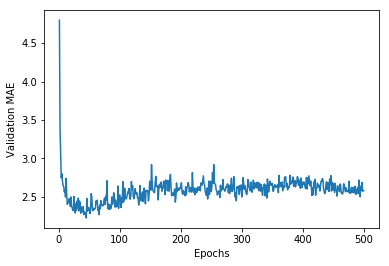

In [14]:
plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

It may be a bit hard to see the plot due to scaling issues and relatively high variance. Let's:

- Omit the first 10 data points, which are on a different scale from the rest of the curve.
- Replace each point with an exponential moving average of the previous points, to obtain a smooth curve.

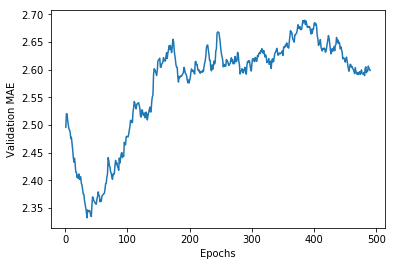

In [15]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

According to this plot, it seems that validation MAE stops improving significantly after 80 epochs. Past that point, we start overfitting.

In [16]:
model = build_model()

model.fit(X_train, y_train, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(X_test, y_test)

102/102 [==============================] - 0s 512us/step


In [17]:
test_mae_score

2.6728993677625468